# Database

In [6]:
import torch.utils.data
from torchvision import datasets, transforms
import numpy as np
import pandas as pd

from torch import nn, optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Define the function as per the problem statement
def compute_function(x, y, t):
    term1 = (0.2 + 0.1 * np.sin(2 * np.pi * (x - 0.1 * t)) * np.cos(2 * np.pi * y)) * (x > t * y)
    term2 = (0.7 + 0.2 * np.cos(6. * np.pi * x) * np.sin(2 * np.pi * (y - 0.1 * t))) * (x <= t * y)
    return term1 + term2

# Define the dataset class
class Function2DDataset(Dataset):
    def __init__(self, t_range=(0, 3), num_samples=1024, grid_size=28):
        """
        t_range: tuple, the range of the parameter t (default: [0, 3])
        num_samples: int, number of samples for different t values
        grid_size: int, number of grid points along x and y axes
        """
        self.t_values = np.linspace(t_range[0], t_range[1], num_samples)
        self.grid_size = grid_size
        self.x_values = np.linspace(0, 1, grid_size)
        self.y_values = np.linspace(0, 1, grid_size)
        self.xx, self.yy = np.meshgrid(self.x_values, self.y_values)

    def __len__(self):
        return len(self.t_values)

    def __getitem__(self, idx):
        t = self.t_values[idx]
        zz = compute_function(self.xx, self.yy, t)
        # Convert to PyTorch tensor
        zz_tensor = torch.tensor(zz, dtype=torch.float32).unsqueeze(0)  # Add channel dimension for CNNs
        t_tensor = torch.tensor(t, dtype=torch.float32)  # Use t as a pseudo-label
        return zz_tensor, t_tensor

grid_size = 256
# Create dataset and dataloader
dataset = Function2DDataset(num_samples=180, grid_size=grid_size)  # More samples for training
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset, batch_size=5, shuffle=True)

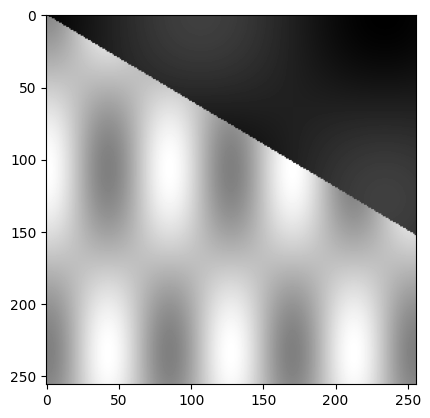

In [8]:
import matplotlib.pyplot as plt
plt.imshow(dataset[100][0].squeeze(), cmap='gray')

# Denoising autoencoder (no convolutional: borderline with RAM)

In [ ]:
class DAE(nn.Module):
    def __init__(self):
        super().__init__()

        # self.fc1 = nn.Linear(784, 512)
        # self.fc2 = nn.Linear(512, 256)
        # self.fc3 = nn.Linear(256, 128)

        # self.fc4 = nn.Linear(128, 256)
        # self.fc5 = nn.Linear(256, 512)
        # self.fc6 = nn.Linear(512, 784)



        # # self.fc1 = nn.Linear(2500, 1500)
        # # self.fc2 = nn.Linear(1500, 1024)
        # # self.fc3 = nn.Linear(1024, 512)

        # # self.fc4 = nn.Linear(512, 1024)
        # # self.fc5 = nn.Linear(1024, 1500)
        # # self.fc6 = nn.Linear(1500,2500)


        # self.fc1 = nn.Linear(grid_size**2, (grid_size//4)**2)
        # self.fc2 = nn.Linear((grid_size//4)**2, (grid_size//16)**2)
        # self.fc3 = nn.Linear((grid_size//16)**2, (grid_size//64)**2)
        # # self.fc3b = nn.Linear((grid_size//64)**2, 1)

        # # self.fc4a= nn.Linear(1, (grid_size//64)**2)
        # self.fc4 = nn.Linear((grid_size//64)**2, (grid_size//16)**2)
        # self.fc5 = nn.Linear((grid_size//16)**2, (grid_size//4)**2)
        # self.fc6 = nn.Linear((grid_size//4)**2,(grid_size)**2)


        self.fc1 = nn.Linear(grid_size**2, (grid_size//2)**2)
        self.fc2 = nn.Linear((grid_size//2)**2, (grid_size//4)**2)
        self.fc3 = nn.Linear((grid_size//4)**2, (grid_size//8)**2)
        # self.fc3b = nn.Linear((grid_size//64)**2, 1)

        # self.fc4a= nn.Linear(1, (grid_size//64)**2)
        self.fc4 = nn.Linear((grid_size//8)**2, (grid_size//4)**2)
        self.fc5 = nn.Linear((grid_size//4)**2, (grid_size//2)**2)
        self.fc6 = nn.Linear((grid_size//2)**2,(grid_size)**2)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):

        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.relu(self.fc3(h2))

    def decode(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        return self.sigmoid(self.fc6(h5))

    def forward(self, x):
        q = self.encode(x.view(-1, grid_size**2))

        return self.decode(q)

In [ ]:
def train(epoch, model, train_loader, optimizer,  cuda=True):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        data_noise = 0.1*torch.randn(data.shape).to(device)
        data_noise = data # + data_noise

        recon_batch = model(data_noise.to(device))
        loss = criterion(recon_batch, data.view(data.size(0), -1).to(device))
        loss.backward()

        train_loss += loss.item() * len(data)
        optimizer.step()

        if batch_idx % 4 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                                                                           100. * batch_idx /
                                                                           len(train_loader),
                                                                           loss.item()))

    print('====&gt; Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))


In [ ]:
epochs = 100

model = DAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
for epoch in range(1, epochs + 1):
    train(epoch, model, train_loader, optimizer, True)

Train Epoch: 1 [0/1024 (0%)]	Loss: 0.067560
Train Epoch: 1 [512/1024 (50%)]	Loss: 0.035869
====&gt; Epoch: 1 Average loss: 0.0471
Train Epoch: 2 [0/1024 (0%)]	Loss: 0.037461
Train Epoch: 2 [512/1024 (50%)]	Loss: 0.033111
====&gt; Epoch: 2 Average loss: 0.0345
Train Epoch: 3 [0/1024 (0%)]	Loss: 0.029486
Train Epoch: 3 [512/1024 (50%)]	Loss: 0.034099
====&gt; Epoch: 3 Average loss: 0.0308
Train Epoch: 4 [0/1024 (0%)]	Loss: 0.025105
Train Epoch: 4 [512/1024 (50%)]	Loss: 0.022314
====&gt; Epoch: 4 Average loss: 0.0215
Train Epoch: 5 [0/1024 (0%)]	Loss: 0.015631
Train Epoch: 5 [512/1024 (50%)]	Loss: 0.014242
====&gt; Epoch: 5 Average loss: 0.0137
Train Epoch: 6 [0/1024 (0%)]	Loss: 0.011642
Train Epoch: 6 [512/1024 (50%)]	Loss: 0.009662
====&gt; Epoch: 6 Average loss: 0.0100
Train Epoch: 7 [0/1024 (0%)]	Loss: 0.008063
Train Epoch: 7 [512/1024 (50%)]	Loss: 0.007222
====&gt; Epoch: 7 Average loss: 0.0074
Train Epoch: 8 [0/1024 (0%)]	Loss: 0.006199
Train Epoch: 8 [512/1024 (50%)]	Loss: 0.006281

Image 0 with label 1.545454502105713
Image 1 with label 1.0791789293289185
Image 2 with label 2.6979472637176514
Image 3 with label 0.929618775844574
Image 4 with label 2.598240375518799


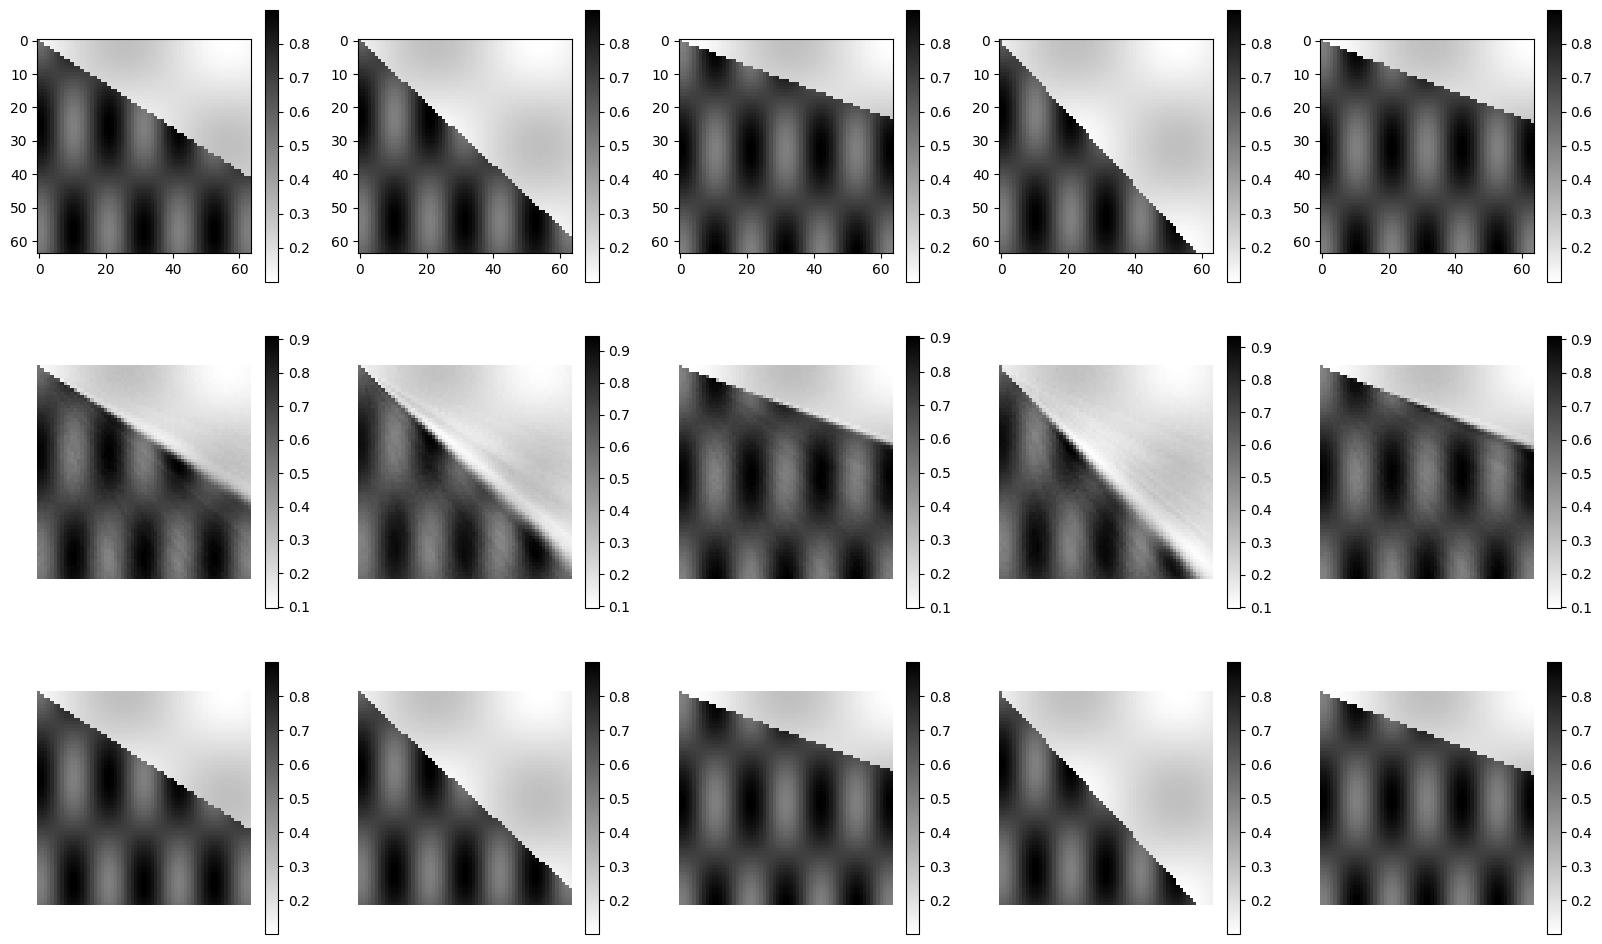

In [ ]:
import matplotlib.pyplot as plt
for batch_idx, (data, labels) in enumerate(test_loader):
    data=data.to(device)
    optimizer.zero_grad()

    data_noise = 0.01*torch.randn(data.shape).to(device)
    data_noise = data #+ data_noise

    recon_batch = model(data_noise.to(device))
    break


plt.figure(figsize=(20, 12))
for i in range(5):

    print(f"Image {i} with label {labels[i]}")
    plt.subplot(3, 5, 1+i)
    plt.imshow(data_noise[i, :, :, :].view(
        grid_size, grid_size).detach().cpu().numpy(), cmap='binary')
    plt.colorbar()
    plt.subplot(3, 5, 6+i)
    plt.imshow(recon_batch[i, :].view(grid_size, grid_size).detach().cpu().numpy(), cmap='binary')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(3, 5, 11+i)
    plt.imshow(data[i, :, :, :].view(grid_size, grid_size).detach().cpu().numpy(), cmap='binary')
    plt.colorbar()
    plt.axis('off')
plt.show()

In [ ]:
model.encode(dataset[100][0].to(device).view(-1, (grid_size)**2)).cpu().detach().numpy().squeeze()

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 1.4166386, 0.       , 6.9811974,
       0.       , 0.       , 0.       , 0.0146046, 3.194632 , 0.       ,
       0.       , 1.6311764, 2.6820867, 0.       , 0.       , 0.       ,
       0.       , 3.8173554, 0.       , 0.       , 0.       , 7.3114905,
       3.4972565, 3.1739774, 3.9297822, 5.1457014, 0.       , 0.       ,
       0.       , 0.       , 0.       , 4.790278 , 0.       , 0.       ,
       4.456779 , 3.9407568, 1.305089 , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 3.7085533,
       0.       , 0.       , 0.       , 4.2374253, 5.049277 , 0.       ,
       1.848299 , 0.       , 4.2597566, 4.111871 ], dtype=float32)

In [ ]:
print(model.fc1.weight.shape)
print(model.fc2.weight.shape)
print(model.fc3.weight.shape)
# print(model.fc3b.weight.shape)
# print(model.fc4a.weight.shape)
print(model.fc4.weight.shape)
print(model.fc5.weight.shape)
print(model.fc6.weight.shape)


torch.Size([1024, 4096])
torch.Size([256, 1024])
torch.Size([64, 256])
torch.Size([256, 64])
torch.Size([1024, 256])
torch.Size([4096, 1024])


In [ ]:
model(dataset[100][0].to(device)).shape
dataset[100][0].to(device).shape

torch.Size([1, 64, 64])

In [ ]:
def train_on_error(epoch, old_model, error_model, train_loader, optimizer,  cuda=True):
    error_model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        old_model_batch = old_model(data)
        error_batch = old_model_batch - data.view((-1,1,grid_size**2))
        predict_error_batch = error_model(data)
        loss = criterion(error_batch, predict_error_batch)
        loss.backward()

        train_loss += loss.item() * len(data)
        optimizer.step()

        if batch_idx % 4 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                                                                           100. * batch_idx /
                                                                           len(train_loader),
                                                                           loss.item()))

    print('====&gt; Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))


In [ ]:
class DAE_non_positive(nn.Module):
    def __init__(self):
        super().__init__()


        self.fc1 = nn.Linear(grid_size**2, (grid_size//2)**2)
        self.fc2 = nn.Linear((grid_size//2)**2, (grid_size//4)**2)
        self.fc3 = nn.Linear((grid_size//4)**2, (grid_size//8)**2)
        # self.fc3b = nn.Linear((grid_size//64)**2, 1)

        # self.fc4a= nn.Linear(1, (grid_size//64)**2)
        self.fc4 = nn.Linear((grid_size//8)**2, (grid_size//4)**2)
        self.fc5 = nn.Linear((grid_size//4)**2, (grid_size//2)**2)
        self.fc6 = nn.Linear((grid_size//2)**2,(grid_size)**2)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def encode(self, x):

        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.relu(self.fc3(h2))

    def decode(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        return self.tanh(self.fc6(h5))

    def forward(self, x):
        q = self.encode(x.view(-1, grid_size**2))

        return self.decode(q)

In [ ]:
epochs = 20

error_model = DAE_non_positive().to(device)
error_optimizer = optim.Adam(error_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
for epoch in range(1, epochs + 1):
    train_on_error(epoch, model, error_model, train_loader, error_optimizer, True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([128, 4096])) that is different to the input size (torch.Size([128, 128, 4096])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Epoch: 1 [0/1024 (0%)]	Loss: 0.070095
Train Epoch: 1 [512/1024 (50%)]	Loss: 0.071088
====&gt; Epoch: 1 Average loss: 0.0674
Train Epoch: 2 [0/1024 (0%)]	Loss: 0.057600
Train Epoch: 2 [512/1024 (50%)]	Loss: 0.051775
====&gt; Epoch: 2 Average loss: 0.0551
Train Epoch: 3 [0/1024 (0%)]	Loss: 0.049607
Train Epoch: 3 [512/1024 (50%)]	Loss: 0.048579
====&gt; Epoch: 3 Average loss: 0.0486
Train Epoch: 4 [0/1024 (0%)]	Loss: 0.051935
Train Epoch: 4 [512/1024 (50%)]	Loss: 0.043295
====&gt; Epoch: 4 Average loss: 0.0467
Train Epoch: 5 [0/1024 (0%)]	Loss: 0.048073
Train Epoch: 5 [512/1024 (50%)]	Loss: 0.042842
====&gt; Epoch: 5 Average loss: 0.0439
Train Epoch: 6 [0/1024 (0%)]	Loss: 0.044420
Train Epoch: 6 [512/1024 (50%)]	Loss: 0.038330
====&gt; Epoch: 6 Average loss: 0.0424
Train Epoch: 7 [0/1024 (0%)]	Loss: 0.043866
Train Epoch: 7 [512/1024 (50%)]	Loss: 0.038488
====&gt; Epoch: 7 Average loss: 0.0418
Train Epoch: 8 [0/1024 (0%)]	Loss: 0.040610
Train Epoch: 8 [512/1024 (50%)]	Loss: 0.041468

In [ ]:
import matplotlib.pyplot as plt
for batch_idx, (data, labels) in enumerate(test_loader):
    data=data.to(device)
    optimizer.zero_grad()
    z =
    recon_batch = model(data)
    error_batch = error_model(recon_batch.to(device)).view((-1,1,grid_size, grid_size))
    impr_batch = recon_batch.view((-1,1,grid_size, grid_size))-error_batch
    break


plt.figure(figsize=(20, 12))
for i in range(5):

    print(f"Image {i} with label {labels[i]}")
    plt.subplot(4, 5, 1+i)
    plt.imshow(data[i, :, :, :].view(
        grid_size, grid_size).detach().cpu().numpy(), cmap='binary')
    plt.colorbar()
    plt.subplot(4, 5, 6+i)
    plt.imshow(recon_batch[i, :].view(grid_size, grid_size).detach().cpu().numpy(), cmap='binary')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(4, 5, 11+i)
    plt.imshow(error_batch[i, :, :, :].view(grid_size, grid_size).detach().cpu().numpy(), cmap='binary')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(4, 5, 16+i)
    plt.imshow(impr_batch[i, :, :, :].view(grid_size, grid_size).detach().cpu().numpy(), cmap='binary')
    plt.colorbar()
    plt.axis('off')
plt.show()

SyntaxError: invalid syntax (<ipython-input-22-ee3291dac059>, line 5)

# Convolutional Autoencoder Denoiser

In [9]:
# Simple CNN model similar to MNIST example
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 24, 2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(24, 48, 2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(48, 96, 2, stride=2, padding=0)
        self.conv4 = nn.Conv2d(96, 192, 2, stride=2, padding=0)
        self.conv5 = nn.Conv2d(192, 378, 2, stride=2, padding=0)
        self.conv6 = nn.Conv2d(378, 378, 2, stride=2, padding=0)
        self.conv7 = nn.Conv2d(378, 378, 2, stride=2, padding=0)

        self.batchnorm1 = nn.BatchNorm2d(24)
        self.batchnorm2 = nn.BatchNorm2d(48)
        self.batchnorm3 = nn.BatchNorm2d(96)
        self.batchnorm4 = nn.BatchNorm2d(192)
        self.batchnorm5 = nn.BatchNorm2d(378)
        self.batchnorm6 = nn.BatchNorm2d(378)

        self.elu1 = nn.ELU(True)
        self.elu2 = nn.ELU(True)
        self.elu3 = nn.ELU(True)
        self.elu4 = nn.ELU(True)
        self.elu5 = nn.ELU(True)
        self.elu6 = nn.ELU(True)

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.lin_encoder = nn.Linear(1512, 10)

        self.lin_decoder = nn.Linear(10, 1512)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(378, 2, 2))
        self.convt1 = nn.ConvTranspose2d(378, 378, 2, stride=2, padding=0, output_padding=0)
        self.convt2 = nn.ConvTranspose2d(378, 378, 2, stride=2, padding=0, output_padding=0)
        self.convt3 = nn.ConvTranspose2d(378, 192, 2, stride=2, padding=0, output_padding=0)
        self.convt4 = nn.ConvTranspose2d(192, 96, 2, stride=2, padding=0, output_padding=0)
        self.convt5 = nn.ConvTranspose2d(96, 48, 2, stride=2, padding=0, output_padding=0)
        self.convt6 = nn.ConvTranspose2d(48, 24, 2, stride=2, padding=0, output_padding=0)
        self.convt7 = nn.ConvTranspose2d(24, 1, 2, stride=2, padding=0, output_padding=0)
        self.batchnormt1 = nn.BatchNorm2d(378)
        self.batchnormt2 = nn.BatchNorm2d(378)
        self.batchnormt3 = nn.BatchNorm2d(192)
        self.batchnormt4 = nn.BatchNorm2d(96)
        self.batchnormt5 = nn.BatchNorm2d(48)
        self.batchnormt6 = nn.BatchNorm2d(24)
        self.elutr1 = nn.ELU(True)
        self.elutr2 = nn.ELU(True)
        self.elutr3 = nn.ELU(True)
        self.elutr4 = nn.ELU(True)
        self.elutr5 = nn.ELU(True)
        self.elutr6 = nn.ELU(True)


    def encode(self,x):
        x = self.elu1(self.batchnorm1(self.conv1(x)))
        x = self.elu2(self.batchnorm2(self.conv2(x)))
        x = self.elu3(self.batchnorm3(self.conv3(x)))
        x = self.elu4(self.batchnorm4(self.conv4(x)))
        x = self.elu5(self.batchnorm5(self.conv5(x)))
        x = self.elu6(self.batchnorm6(self.conv6(x)))
        x = self.conv7(x)
        x = self.lin_encoder(self.flatten(x))
        return x

    def decode(self, x):
        x = self.unflatten(self.lin_decoder(x))
        x = self.elutr1(self.batchnormt1(self.convt1(x)))
        x = self.elutr2(self.batchnormt2(self.convt2(x)))
        x = self.elutr3(self.batchnormt3(self.convt3(x)))
        x = self.elutr4(self.batchnormt4(self.convt4(x)))
        x = self.elutr5(self.batchnormt5(self.convt5(x)))
        x = self.elutr6(self.batchnormt6(self.convt6(x)))
        x = self.convt7(x)
        return x

    def forward(self, x):
        x = self.decode(self.encode(x))  # Output the t value
        return x


In [10]:


# Initialize model, loss function, and optimizer
model = CNNModel().to(device)
criterion = nn.MSELoss()  # Regression task to predict t
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs=1000


def train(epoch, model, train_loader, optimizer,  cuda=True):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        data_noise = 0.1*torch.randn(data.shape).to(device)
        data_noise = data # + data_noise

        recon_batch = model(data_noise.to(device))
        loss = criterion(recon_batch.to(device), data.to(device))
        loss.backward()

        train_loss += loss.item() * len(data)
        optimizer.step()

        if batch_idx % 4 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6e}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                                                                           100. * batch_idx /len(train_loader),
                                                                           loss.item()))

    print('====&gt; Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))
    return loss.item()

import time
tic = time.time()
toc=time.time()
losses=np.zeros(epochs)
for epoch in range(1, epochs + 1):
    losses[epoch-1]=train(epoch, model, train_loader, optimizer, True)
    print("one epoch time ", time.time()-toc)
    toc = time.time()
toc = time.time()
print("Total time ", toc-tic)
print("Average time ", (toc-tic)/epochs)

Train Epoch: 1 [0/180 (0%)]	Loss: 1.498230e+00
Train Epoch: 1 [64/180 (33%)]	Loss: 4.412092e-01
Train Epoch: 1 [128/180 (67%)]	Loss: 2.021265e-01
====&gt; Epoch: 1 Average loss: 0.5333
one epoch time  1.369896650314331
Train Epoch: 2 [0/180 (0%)]	Loss: 1.330339e-01
Train Epoch: 2 [64/180 (33%)]	Loss: 9.474492e-02
Train Epoch: 2 [128/180 (67%)]	Loss: 8.060160e-02
====&gt; Epoch: 2 Average loss: 0.0918
one epoch time  0.8347508907318115
Train Epoch: 3 [0/180 (0%)]	Loss: 5.484995e-02
Train Epoch: 3 [64/180 (33%)]	Loss: 5.974447e-02
Train Epoch: 3 [128/180 (67%)]	Loss: 4.480051e-02
====&gt; Epoch: 3 Average loss: 0.0506
one epoch time  0.789067268371582
Train Epoch: 4 [0/180 (0%)]	Loss: 3.805271e-02
Train Epoch: 4 [64/180 (33%)]	Loss: 3.289096e-02
Train Epoch: 4 [128/180 (67%)]	Loss: 2.886316e-02
====&gt; Epoch: 4 Average loss: 0.0340
one epoch time  0.7890365123748779
Train Epoch: 5 [0/180 (0%)]	Loss: 2.862605e-02
Train Epoch: 5 [64/180 (33%)]	Loss: 2.769370e-02
Train Epoch: 5 [128/180 (6

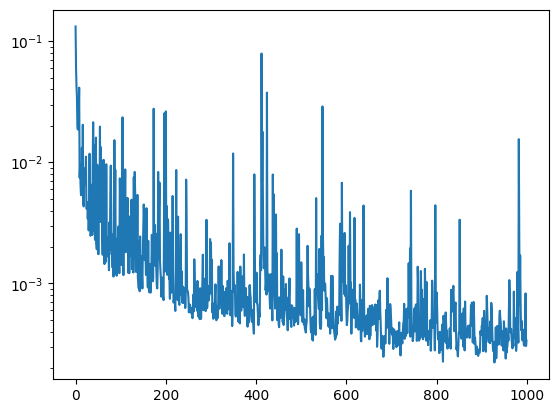

In [11]:
plt.semilogy(losses)

Image 0 with label 2.7988827228546143
Image 1 with label 2.195530652999878
Image 2 with label 2.413407802581787
Image 3 with label 0.11731843650341034
Image 4 with label 2.4636871814727783


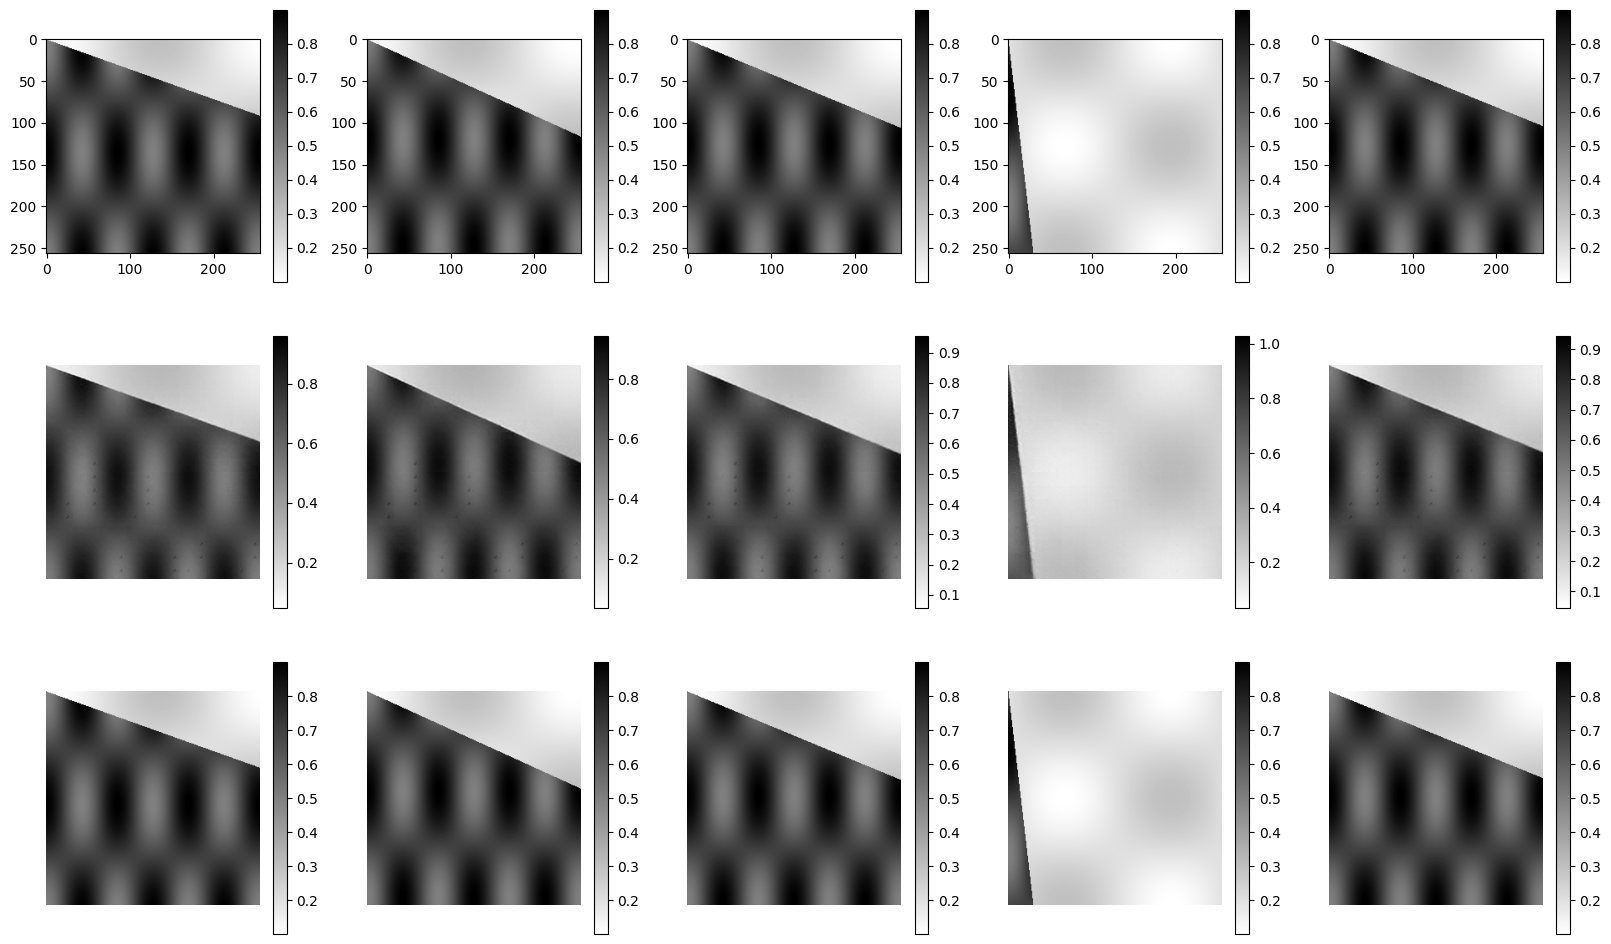

In [12]:
import matplotlib.pyplot as plt
for batch_idx, (data, labels) in enumerate(test_loader):
    data=data.to(device)
    optimizer.zero_grad()

    data_noise = 0.01*torch.randn(data.shape).to(device)
    data_noise = data #+ data_noise

    recon_batch = model(data_noise.to(device))
    break


plt.figure(figsize=(20, 12))
for i in range(5):

    print(f"Image {i} with label {labels[i]}")
    plt.subplot(3, 5, 1+i)
    plt.imshow(data_noise[i, :, :, :].view(
        grid_size, grid_size).detach().cpu().numpy(), cmap='binary')
    plt.colorbar()
    plt.subplot(3, 5, 6+i)
    plt.imshow(recon_batch[i, :].view(grid_size, grid_size).detach().cpu().numpy(), cmap='binary')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(3, 5, 11+i)
    plt.imshow(data[i, :, :, :].view(grid_size, grid_size).detach().cpu().numpy(), cmap='binary')
    plt.colorbar()
    plt.axis('off')
plt.show()

In [13]:
#Train denoiser



# Initialize model, loss function, and optimizer
denoiser_model = CNNModel().to(device)
criterion = nn.MSELoss()  # Regression task to predict t
optimizer = optim.Adam(denoiser_model.parameters(), lr=0.001)
epochs=1000


def train_denoiser(epoch, denoiser_model, old_model, train_loader, optimizer,  cuda=True):
    denoiser_model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        old_model_batch = old_model(data)

        recon_batch = denoiser_model(old_model_batch.to(device))
        loss = criterion(recon_batch.to(device), data.to(device))
        loss.backward()

        train_loss += loss.item() * len(data)
        optimizer.step()

        if batch_idx % 4 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6e}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                                                                           100. * batch_idx /len(train_loader),
                                                                           loss.item()))

    print('====&gt; Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))
    return loss.item()

import time
tic = time.time()
toc=time.time()
losses=np.zeros(epochs)
for epoch in range(1, epochs + 1):
    losses[epoch-1]=train_denoiser(epoch, denoiser_model, model, train_loader, optimizer, True)
    print("one epoch time ", time.time()-toc)
    toc = time.time()
toc = time.time()
print("Total time ", toc-tic)
print("Average time ", (toc-tic)/epochs)

Train Epoch: 1 [0/180 (0%)]	Loss: 2.778676e+00
Train Epoch: 1 [64/180 (33%)]	Loss: 1.662831e+00
Train Epoch: 1 [128/180 (67%)]	Loss: 1.368524e+00
====&gt; Epoch: 1 Average loss: 1.7546
one epoch time  1.009328842163086
Train Epoch: 2 [0/180 (0%)]	Loss: 1.198582e+00
Train Epoch: 2 [64/180 (33%)]	Loss: 1.096789e+00
Train Epoch: 2 [128/180 (67%)]	Loss: 9.790673e-01
====&gt; Epoch: 2 Average loss: 1.0536
one epoch time  0.9772117137908936
Train Epoch: 3 [0/180 (0%)]	Loss: 8.683748e-01
Train Epoch: 3 [64/180 (33%)]	Loss: 8.341084e-01
Train Epoch: 3 [128/180 (67%)]	Loss: 7.331623e-01
====&gt; Epoch: 3 Average loss: 0.7930
one epoch time  0.9278099536895752
Train Epoch: 4 [0/180 (0%)]	Loss: 7.364948e-01
Train Epoch: 4 [64/180 (33%)]	Loss: 6.458063e-01
Train Epoch: 4 [128/180 (67%)]	Loss: 5.573770e-01
====&gt; Epoch: 4 Average loss: 0.5995
one epoch time  0.9238481521606445
Train Epoch: 5 [0/180 (0%)]	Loss: 5.337542e-01
Train Epoch: 5 [64/180 (33%)]	Loss: 4.564067e-01
Train Epoch: 5 [128/180 (

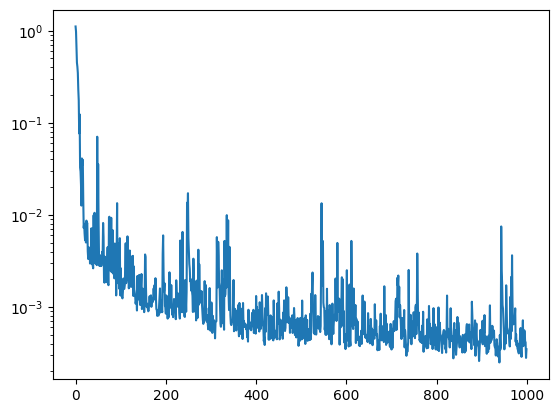

In [14]:
plt.semilogy(losses)

Image 0 with label 1.4748603105545044
Image 1 with label 2.363128423690796
Image 2 with label 0.25139665603637695
Image 3 with label 2.1787710189819336
Image 4 with label 1.9441341161727905


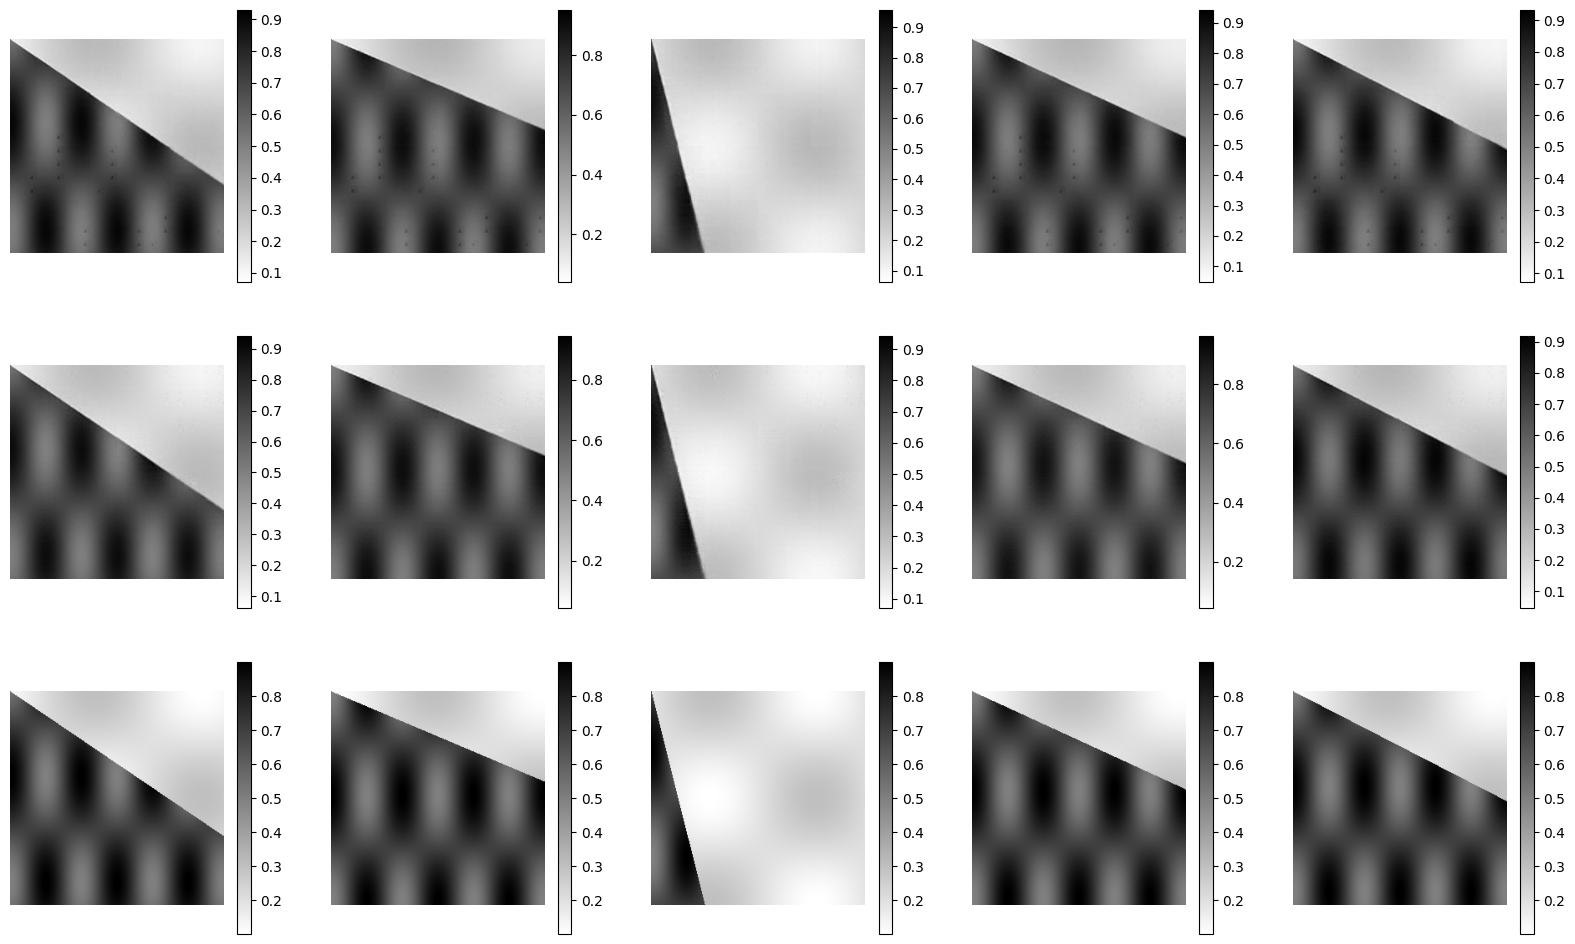

In [17]:
import matplotlib.pyplot as plt
for batch_idx, (data, labels) in enumerate(test_loader):
    data=data.to(device)
    optimizer.zero_grad()
    recon_batch = model(data)
    denoiser_batch = denoiser_model(recon_batch)

    break


plt.figure(figsize=(20, 12))
for i in range(5):

    print(f"Image {i} with label {labels[i]}")
    plt.subplot(3, 5, 1+i)
    plt.imshow(recon_batch[i, :].view(grid_size, grid_size).detach().cpu().numpy(), cmap='binary')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(3, 5, 6+i)
    plt.imshow(denoiser_batch[i, :, :, :].view(grid_size, grid_size).detach().cpu().numpy(), cmap='binary')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(3, 5, 11+i)
    plt.imshow(data[i, :, :, :].view(grid_size, grid_size).detach().cpu().numpy(), cmap='binary')
    plt.colorbar()
    plt.axis('off')
plt.savefig("convAE.pdf")

plt.show()